In [1]:
import tensorflow as tf
import numpy as np
import h5py


c:\Users\Raaghav\miniconda3\envs\tf\lib\site-packages\h5py\__init__.py:36: UserWarning: h5py is running against HDF5 1.14.6 when it was built against 1.14.5, this may cause problems
  _warn(("h5py is running against HDF5 {0} when it was built against {1}, "


In [2]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

In [3]:
unsub = '../data/Dataset_Specific_Unlabelled.h5'

In [4]:
with h5py.File(unsub, 'r') as f:
    print("Keys inside file:", list(f.keys()))
    ds = f['jet'][:]

Keys inside file: ['jet']


In [5]:
ds /= ds.max()
channel_max = ds.max(axis=(0,1,2))

In [6]:
encoder = tf.keras.models.load_model(
    "../models/vicreg_encoder.h5",
    compile=False
)
encoder.trainable = False


In [7]:
latent_dim = encoder.output_shape[-1]
X_disk = np.memmap(
    "vicreg_latents.dat",
    dtype="float32",
    mode="w+",
    shape=(len(ds), latent_dim)
)

cursor = 0
chunk_size = 128

for i in range(0, len(ds), chunk_size):
    x = tf.convert_to_tensor(ds[i:i+chunk_size])
    z = encoder(x, training=False).numpy()
    z = z/np.linalg.norm(z, axis = 1, keepdims= True)
    X_disk[cursor:cursor+z.shape[0]] = z
    cursor += z.shape[0]

X_disk.flush()


In [8]:
from sklearn.mixture import GaussianMixture

gmm = GaussianMixture(
    n_components=5,
    covariance_type="diag",  # VERY IMPORTANT
    random_state=42
)
labels = gmm.fit_predict(X_disk)


In [9]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
latent_2d = pca.fit_transform(X_disk)


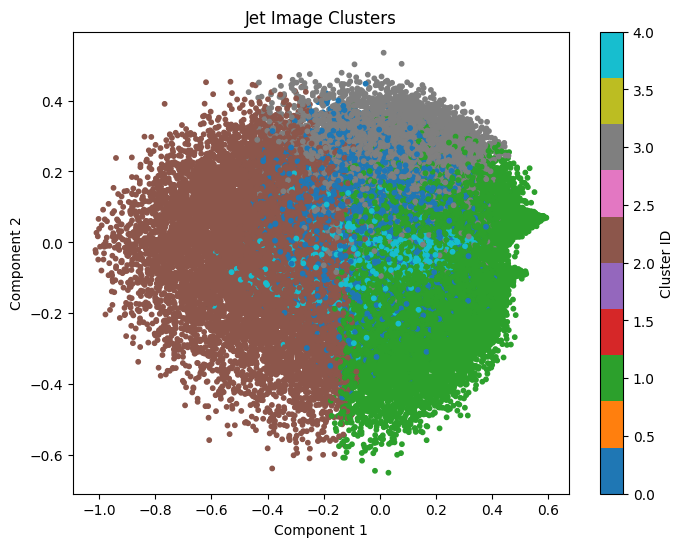

In [10]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))
plt.scatter(
    latent_2d[:,0],
    latent_2d[:,1],
    c=labels,
    cmap='tab10',
    s=10
)
plt.colorbar(label="Cluster ID")
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.title("Jet Image Clusters")
plt.show()


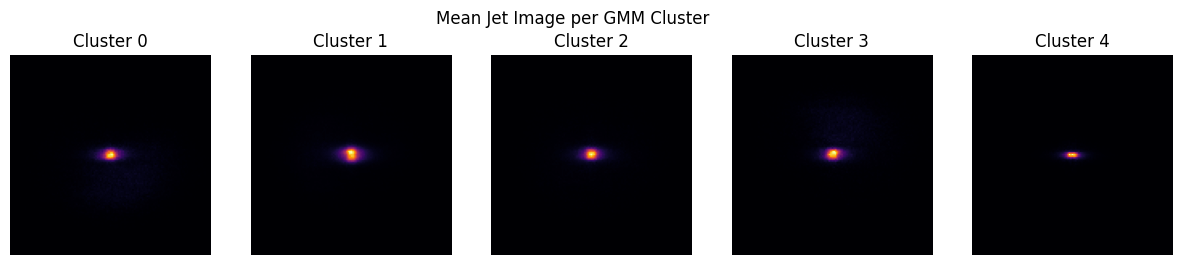

In [11]:
import numpy as np

k = gmm.n_components

fig, axes = plt.subplots(1, k, figsize=(15, 3))

for i in range(k):
    mean_jet = ds[labels == i].mean(axis=0)
    axes[i].imshow(mean_jet[:, :, 0], cmap="inferno")
    axes[i].set_title(f"Cluster {i}")
    axes[i].axis("off")

plt.suptitle("Mean Jet Image per GMM Cluster")
plt.show()
